#Predicting Marital Status Based on Census Data
### i310D - goodTeam - Julia F., Kyle C., Sydney F., Tyler H.

##Import packages and read in file:


*   *duckdb* is a package that allows SQL queries to be executed in the notebook



In [12]:
import pandas as pd
import duckdb

df = pd.read_json('data.json')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,PWGTP,WAGP,VALP,WKHP,RNTP,AGEP,DIS,SEX,MAR,ENG,NATIVITY,VEH,MIL,SCHL,MARHT,COW,JWTRNS,PUMA,ST
1,13,0,0,0,0,18,2,1,5,4,2,-1,4,16,0,0,0,05307,48
2,25,6800,0,8,0,21,2,1,5,0,1,-1,4,19,0,1,0,05306,48
3,55,0,0,0,0,18,2,2,5,0,1,-1,4,16,0,0,0,05306,48
4,47,12000,0,15,0,22,2,2,5,0,1,-1,4,19,0,3,1,05306,48


##Clean data before implementing classification models

In [13]:
# renaming columns
df.columns = [
    'person_weight', 'salary',   'property_value', 'unusual_hours', 'monthly_rent',
    'age', 'disability_recode', 'sex', 'marital_status', 'english_abilities',
    'nativity', 'vehicles', 'military_service', 'educational_attainment',
    'times_married', 'worker_class', 'work_transportation', 'puma', 'state'
]
df.head()

,person_weight,salary,property_value,unusual_hours,monthly_rent,age,disability_recode,sex,marital_status,english_abilities,nativity,vehicles,military_service,educational_attainment,times_married,worker_class,work_transportation,puma,state
0,PWGTP,WAGP,VALP,WKHP,RNTP,AGEP,DIS,SEX,MAR,ENG,NATIVITY,VEH,MIL,SCHL,MARHT,COW,JWTRNS,PUMA,ST
1,13,0,0,0,0,18,2,1,5,4,2,-1,4,16,0,0,0,05307,48
2,25,6800,0,8,0,21,2,1,5,0,1,-1,4,19,0,1,0,05306,48
3,55,0,0,0,0,18,2,2,5,0,1,-1,4,16,0,0,0,05306,48
4,47,12000,0,15,0,22,2,2,5,0,1,-1,4,19,0,3,1,05306,48


In [14]:
# remove first row
df = df.iloc[1:]

In [15]:
# analyze data types
df.dtypes

person_weight             object
salary                    object
property_value            object
unusual_hours             object
monthly_rent              object
age                       object
disability_recode         object
sex                       object
marital_status            object
english_abilities         object
nativity                  object
vehicles                  object
military_service          object
educational_attainment    object
times_married             object
worker_class              object
work_transportation       object
puma                      object
state                     object
dtype: object

In [16]:
# convert strings to int
columns_to_convert = ['person_weight', 'salary', 'property_value', 'unusual_hours', 'monthly_rent',
                      'age', 'disability_recode', 'sex', 'marital_status', 'english_abilities',
                      'nativity', 'vehicles', 'military_service', 'educational_attainment', 'times_married',
                      'worker_class', 'work_transportation', 'puma', 'state']

for column in columns_to_convert:
    df[column] = df[column].astype(int)

In [17]:
# data types are fixed!
df.dtypes

person_weight             int32
salary                    int32
property_value            int32
unusual_hours             int32
monthly_rent              int32
age                       int32
disability_recode         int32
sex                       int32
marital_status            int32
english_abilities         int32
nativity                  int32
vehicles                  int32
military_service          int32
educational_attainment    int32
times_married             int32
worker_class              int32
work_transportation       int32
puma                      int32
state                     int32
dtype: object


*   Change marital status to binary attributes (married/not-married)


In [18]:
# changes marital status to binary attributes
# not married = 0, married = 1
df['marital_status'] = [0 if x != 1 else 1 for x in df['marital_status']]

In [19]:
# drop rows where age < 18
df = df.loc[df['age'] >= 18]

In [20]:
# alter rows where salary is 0
# Adjusted query to round the average salary to the nearest whole number


# avgsal_query = duckdb.query("SELECT ROUND(AVG(CAST(salary AS DOUBLE)), 0) AS avg FROM df WHERE salary <> '0'").to_df()
# avgsal_query['avg'] = avgsal_query['avg'].astype(int)
# avg_salary = avgsal_query['avg'][0]



def zeroToAvg(col):
    avg_pd = duckdb.query(f"SELECT ROUND(AVG(CAST({col} AS DOUBLE)), 0) AS avg FROM df WHERE {col} <> '0'").to_df()
    avg_salary = int(avg_pd['avg'][0])
    df.loc[df[col] == 0, col] = avg_salary

# zeroToAvg("unusual_hours")

In [21]:
# sql zone
# q = duckdb.query("SELECT * FROM df").to_df()
# q

##Exploratory Data Analysis
Understand the data distribution and relationships between features and marital status.


*   This will help us better understand which variables we need to keep/change and which variables have a stronger relationship with marital status






In [22]:
# Descriptive statistics
print(df.describe())


       person_weight         salary  property_value  unusual_hours  \
count    2950.000000    2950.000000    2.950000e+03    2950.000000   
mean      113.851864   56628.596610    3.648033e+05      39.047797   
std        97.377718   86061.934454    6.998701e+05      10.840192   
min         2.000000       0.000000    0.000000e+00       2.000000   
25%        56.000000       0.000000    0.000000e+00      39.000000   
50%        82.000000   30000.000000    0.000000e+00      40.000000   
75%       137.000000   78000.000000    5.000000e+05      40.000000   
max      1477.000000  537000.000000    3.840000e+06      99.000000   

       monthly_rent          age  disability_recode          sex  \
count   2950.000000  2950.000000        2950.000000  2950.000000   
mean     722.054237    43.059661           1.871864     1.504407   
std      953.420312    18.492926           0.334297     0.500065   
min        0.000000    18.000000           1.000000     1.000000   
25%        0.000000    28.000

In [23]:
# Overview of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2950 entries, 1 to 3426
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   person_weight           2950 non-null   int32
 1   salary                  2950 non-null   int32
 2   property_value          2950 non-null   int32
 3   unusual_hours           2950 non-null   int32
 4   monthly_rent            2950 non-null   int32
 5   age                     2950 non-null   int32
 6   disability_recode       2950 non-null   int32
 7   sex                     2950 non-null   int32
 8   marital_status          2950 non-null   int64
 9   english_abilities       2950 non-null   int32
 10  nativity                2950 non-null   int32
 11  vehicles                2950 non-null   int32
 12  military_service        2950 non-null   int32
 13  educational_attainment  2950 non-null   int32
 14  times_married           2950 non-null   int32
 15  worker_class            29

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of marital status
sns.countplot(x='marital_status', data=df)
plt.title('Distribution of Marital Status')
plt.show()

KeyboardInterrupt: 

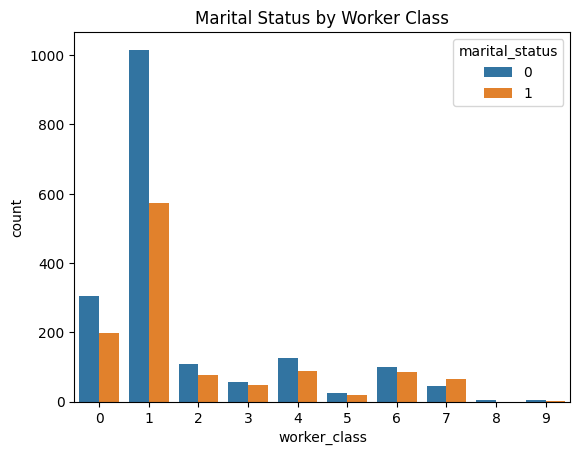

In [ ]:
# Example with Worker Class
sns.countplot(x='worker_class', hue='marital_status', data=df)
plt.title('Marital Status by Worker Class')
plt.xticks()
plt.show()

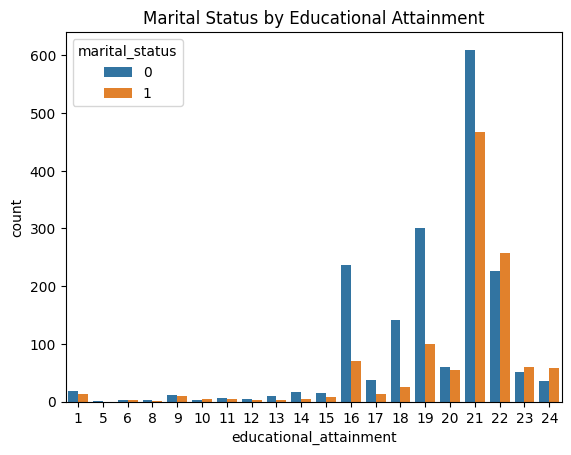

In [ ]:
# Get unique values of educational_attainment and sort them in numerical value 0-
educational_levels = sorted(df['educational_attainment'].unique())

# Plot countplot with sorted educational levels
sns.countplot(x='educational_attainment', hue='marital_status', data=df, order=educational_levels)
plt.title('Marital Status by Educational Attainment')
plt.show()

In [ ]:
from scipy.stats import pearsonr

filtered_df = df[df["marital_status"] == 0]
p = pearsonr(filtered_df["age"], filtered_df["marital_status"])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
!pip install dataprep
from dataprep.eda import create_report

report = create_report(df)
report.show()

# Split data into training and testing sets:

In [ ]:
from sklearn.model_selection import train_test_split

# Identify the target variable
target_column = 'marital_status'

# Create y variable (target variable)
marital_status_set = df[target_column]

# Create X variable (features) by removing the target variable column
X = df.drop(columns=[target_column])

# Features (X) and target variable (y) are ready for splitting
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


EDA for Testing Fairness
- use scikit-learn's classification_report function